Comparing two calculations of the percentage of a census tract's population on well water:
  1. The fraction of a census tract's area NOT served by a public water supply. 
      - This approach was taken by Wamsley et al
  2. Via population density estimates via [CEISIN and Facebook](https://data.humdata.org/dataset/united-states-high-resolution-population-density-maps-demographic-estimates#); [Link 2](https://dataforgood.facebook.com/dfg/tools/high-resolution-population-density-maps).

In [2]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

# Method 1: % Area

In [3]:
WWR_data = geopandas.read_file("/Users/Scott/QGIS/SVI/Penn_Analysis/data/TL_well_water_regions.gpkg", layer="WellWaterRegions")
TL_data = geopandas.read_file("/Users/Scott/QGIS/SVI/Penn_Analysis/data/tl_2022_42_tract/tl_2022_42_tract.shp")

Need a good projection for area, b/c geopandas doesn't do ellipsoidal areas.

PA is split into N as S by the [SPCS](https://www.usgs.gov/faqs/what-state-plane-coordinate-system-can-gps-provide-coordinates-these-values). I'll just go with 6564 (S, in meters), which provides area accuracy even in N PA to three digits, based on spot checks. I also tried out EPSG:32618, but it seemed to give slightly worse results. 

In [4]:
WWR_data_6564 = WWR_data.to_crs(epsg=6564)
TL_data_6564 = TL_data.to_crs(epsg=6564)

In [5]:
WWR_data_6564["WW_area"] = WWR_data_6564.area
TL_data_6564["Tot_area"] = TL_data_6564.area

In [6]:
WWR_data_6564_to_join = WWR_data_6564.loc[:, ["GEOID", "WW_area"]]
area_data = TL_data_6564.merge(
    WWR_data_6564_to_join, 
    how="left", 
    on="GEOID"
)

The tracts without any well water (i.e. completely covered by PWS) will be NA. This means 0, so fill with that.

In [7]:
area_data["WW_area"] = area_data["WW_area"].fillna(0)

In [8]:
area_data["frac_WW_area"] = area_data["WW_area"] / area_data["Tot_area"]

# Method 2: Using Pop Density

In [9]:
density_data = pd.read_csv("/Users/Scott/QGIS/SVI/Penn_Analysis/data/final_output.csv")

CEISIN no-pop estimates can be:
  - 0
    - indicates that a tract had area not served by a PWS, but this area had an estimated population of 0 (i.e. no buildings)
  - NA
    - indicates a tract was 100% served by a PWS, so the WW component is non-existent.

In [10]:
density_data["WWR_sum_pop_est"] = density_data["WWR_sum_pop_est"].fillna(0)

In [11]:
density_data["frac_WW_CEISIN"] = density_data["WWR_sum_pop_est"] / density_data["TL_sum_pop_est"]

# Join Two Estimates

In [12]:
area_data.dtypes

STATEFP           object
COUNTYFP          object
TRACTCE           object
GEOID             object
NAME              object
NAMELSAD          object
MTFCC             object
FUNCSTAT          object
ALAND              int64
AWATER             int64
INTPTLAT          object
INTPTLON          object
geometry        geometry
Tot_area         float64
WW_area          float64
frac_WW_area     float64
dtype: object

In [13]:
density_data.dtypes

STATEFP              int64
COUNTYFP             int64
TRACTCE              int64
GEOID                int64
NAME               float64
                    ...   
Shape_Length       float64
Shape_Area         float64
TL_sum_pop_est     float64
WWR_sum_pop_est    float64
frac_WW_CEISIN     float64
Length: 176, dtype: object

In [14]:
density_data["GEOID"] = density_data["GEOID"].astype("string")
area_data["GEOID"] = area_data["GEOID"].astype("string")

In [15]:
area_data.dtypes

STATEFP                 object
COUNTYFP                object
TRACTCE                 object
GEOID           string[python]
NAME                    object
NAMELSAD                object
MTFCC                   object
FUNCSTAT                object
ALAND                    int64
AWATER                   int64
INTPTLAT                object
INTPTLON                object
geometry              geometry
Tot_area               float64
WW_area                float64
frac_WW_area           float64
dtype: object

In [16]:
density_data.dtypes

STATEFP                     int64
COUNTYFP                    int64
TRACTCE                     int64
GEOID              string[python]
NAME                      float64
                        ...      
Shape_Length              float64
Shape_Area                float64
TL_sum_pop_est            float64
WWR_sum_pop_est           float64
frac_WW_CEISIN            float64
Length: 176, dtype: object

These are NA b/c TL_sum_pop_est == 0
The ACS (in the SVI) also estimates a pop of 0 (E_TOTPOP)

In [17]:
density_data_zero_pops = density_data[density_data["frac_WW_CEISIN"].isna()]

In [18]:
density_data_to_join = density_data.loc[:,["GEOID", "E_TOTPOP", "E_HU", "M_HU", "E_HH", "WWR_sum_pop_est", "frac_WW_CEISIN"]]
comparison_data = area_data.merge(
    density_data_to_join,
    on="GEOID",
    how="outer"
)

In [19]:
comparison_data["pct_point_diff_frac_WW"] = comparison_data["frac_WW_CEISIN"] - comparison_data["frac_WW_area"]

## WW Users at Pop Count

In [20]:
comparison_data["WW_pop_CEISIN"] = comparison_data["E_TOTPOP"] * comparison_data["frac_WW_CEISIN"]
comparison_data["WW_pop_area"] = comparison_data["E_TOTPOP"] * comparison_data["frac_WW_area"]

In [21]:
comparison_data["pop_diff_WW"] = comparison_data["WW_pop_CEISIN"] - comparison_data["WW_pop_area"]

### WW Housing Units Estimate

In [22]:
comparison_data["WW_HU_CEISIN"] = comparison_data["E_HU"] * comparison_data["frac_WW_area"]
comparison_data["WW_HU_CEISIN_lo"] = (comparison_data["E_HU"] - comparison_data["M_HU"]) * comparison_data["frac_WW_area"]
comparison_data["WW_HH_CEISIN"] = comparison_data["E_HH"] * comparison_data["frac_WW_area"]

### Total WW Pop Estimates

According to the paper, this *should* be ~3 million.

In [23]:
comparison_data.loc[:,["WWR_sum_pop_est", "WW_pop_CEISIN", "WW_pop_area", "WW_HU_CEISIN", "WW_HU_CEISIN_lo", "WW_HH_CEISIN"]].sum()

WWR_sum_pop_est    2.417985e+06
WW_pop_CEISIN      2.377883e+06
WW_pop_area        3.924765e+06
WW_HU_CEISIN       1.765295e+06
WW_HU_CEISIN_lo    1.609804e+06
WW_HH_CEISIN       1.530175e+06
dtype: float64

# Plot

## Fractions

<Axes: ylabel='Density'>

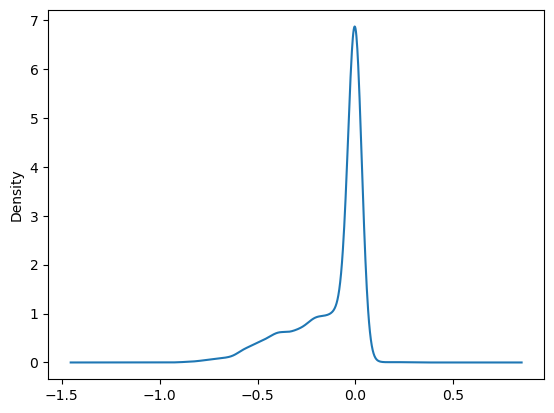

In [24]:
# comparison_data["pct_point_diff_frac_WW"].hist(bins=20)
comparison_data["pct_point_diff_frac_WW"].plot.kde()

In [25]:
sum(abs(comparison_data["pct_point_diff_frac_WW"]) < 0.01), len(comparison_data["pct_point_diff_frac_WW"])

(1790, 3446)

## Pop Diffs

<Axes: >

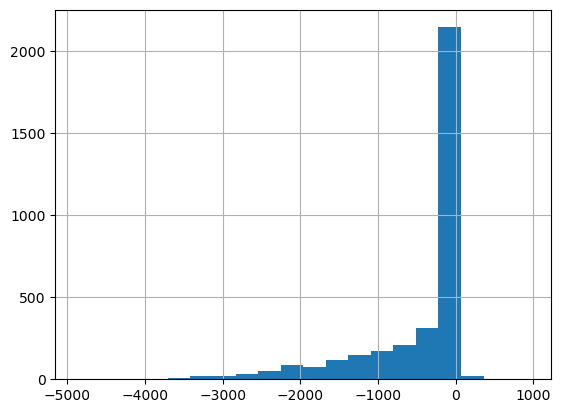

In [26]:
comparison_data["pop_diff_WW"].hist(bins=20)

Text(0, 0.5, 'Proportion per Land Area')

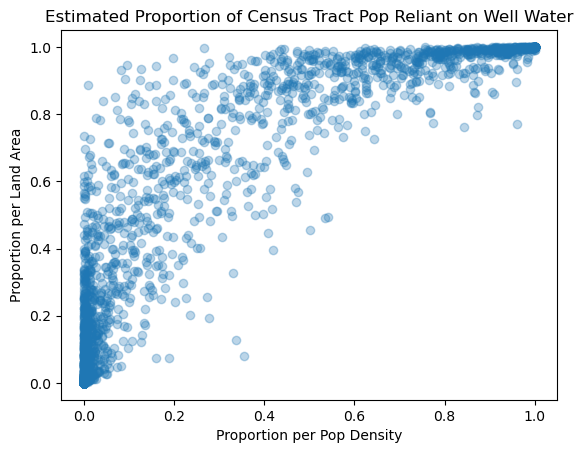

In [27]:
fig, ax = plt.subplots()
ax.scatter(
    comparison_data["frac_WW_CEISIN"], 
    comparison_data["frac_WW_area"],
    alpha=0.3)
ax.set_title("Estimated Proportion of Census Tract Pop Reliant on Well Water")
ax.set_xlabel("Proportion per Pop Density")
ax.set_ylabel("Proportion per Land Area")

Text(0, 0.5, '# Well Water Users, using Land Area')

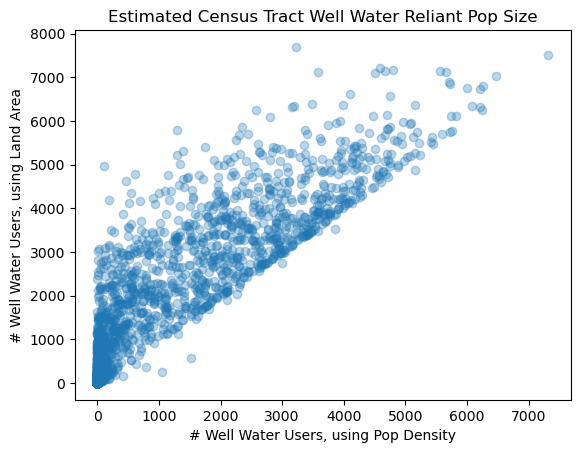

In [28]:
fig, ax = plt.subplots()
ax.scatter(
    comparison_data["WW_pop_CEISIN"], 
    comparison_data["WW_pop_area"],
    alpha=0.3)
ax.set_title("Estimated Census Tract Well Water Reliant Pop Size")
ax.set_xlabel("# Well Water Users, using Pop Density")
ax.set_ylabel("# Well Water Users, using Land Area")

## 3: CEISIN Pop WW vs ACS Pop WW

I think I'll use (proportion of CEISIN total pop est that is in WW area) * E_TOTPOP, rather than just the CEISIN WW pop est, because the ACS should be both more accurate and is for more recent data.

This is just comparing to see how close the two estimates are.

Text(0, 0.5, '# Well Water Users, using CEISIN directly (method 2.1)')

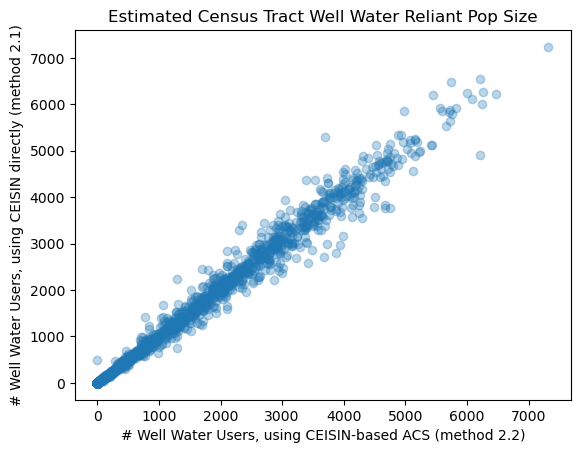

In [38]:
fig, ax = plt.subplots()
ax.scatter(
    comparison_data["WW_pop_CEISIN"], 
    comparison_data["WWR_sum_pop_est"],
    alpha=0.3)
ax.set_title("Estimated Census Tract Well Water Reliant Pop Size")
ax.set_xlabel("# Well Water Users, using CEISIN-based ACS (method 2.2)")
ax.set_ylabel("# Well Water Users, using CEISIN directly (method 2.1)")

Text(0, 0.5, '# Well Water Housing Units, adapting method 2.2')

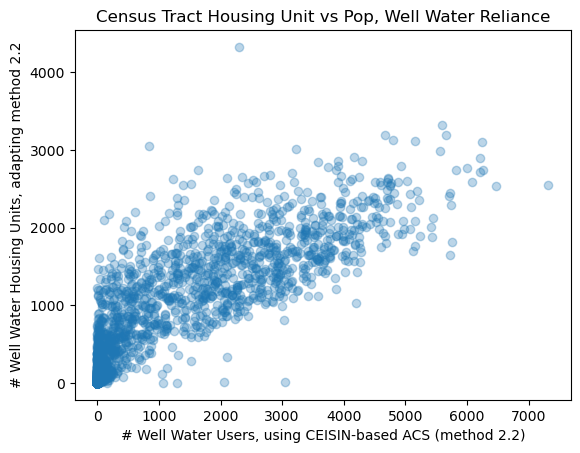

In [37]:
fig, ax = plt.subplots()
ax.scatter(
    comparison_data["WW_pop_CEISIN"], 
    comparison_data["WW_HU_CEISIN"],
    alpha=0.3)
ax.set_title("Census Tract Housing Unit vs Pop, Well Water Reliance")
ax.set_xlabel("# Well Water Users, using CEISIN-based ACS (method 2.2)")
ax.set_ylabel("# Well Water Housing Units, adapting method 2.2")

In [25]:
nonzero_area_data = comparison_data[comparison_data["frac_WW_area"] > 0]
WW_CEISIN_Pop_diffs = (nonzero_area_data["WW_pop_CEISIN"] - nonzero_area_data["WWR_sum_pop_est"]).to_frame(name="diff")

In [26]:
WW_CEISIN_Pop_diffs["quantile"] = WW_CEISIN_Pop_diffs.loc[:,["diff"]].rank() / len(WW_CEISIN_Pop_diffs)

In [27]:
WW_CEISIN_Pop_diffs.sort_values("quantile", inplace=True)

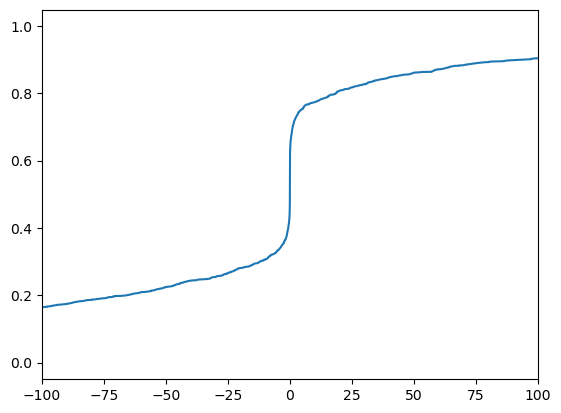

In [28]:
fig, ax = plt.subplots()
ax.set_xlim(-100, 100)
ax.plot("diff", "quantile", data=WW_CEISIN_Pop_diffs)